# Moment tensor based multinomial classifier for Earthquake, Explosion, and Mine/Cavity Collapse targets.  

This jupyter notebook loads input data: moment tensor, eigenvalues, and lune latitude, longitude (spherical projection of eigenvalues). The last column is the label (eq, ex, co) based on independent outside information on explosion-ex and collapse-co classes. However, the earthquake-eq class is assumed based on United States Geological Survey data but could have class identification errors.  It would be worth further examination of outliers in the following results to see if any are miss labeled or have large modeling errors.   

We performed Exploritory Data Analysis with scatter plots of the data with the eigvalue and lune parameters. We identified a class imbalance with 82% eq class and the remaining ex and co classes. The correlation analysis identifies that the lune latitude and lune longitude are strongly negatively correlated.  These two values have been optimized to provided the best seperation between seismic source types.

We use 10 supervised machine learning classifiers based on 2 parameters lune latitude and lune longitude.  

1. Support Vector Machine (SVM)

2. Quadratic Discriminant Analysis (QDA)

3. Logistic Regression Classifier (LGR)

4. Decision Trees Classifier (DTC)

5. K Nearest Neighbor Classifier (KNN)

6. Random Forest Classifier (RFC)

7. ADA Boosting Classifier (ABC) 

8. Gausian Process Classifier (GPC)

9. Gausian Naive Bayes (GNB)

10. Multilayer Perception Classifier (MPC)

We also attempted using Artifical Neural Network (ANN) in a separate Jupyter notebook. 

The classifier models are built using balanced accuracy metric due to the class imbalance. We constructed a pipeline for running a standard scaler on the input data and then creating one over the rest classifiers.  We performed a grid search for the best hyperparameters.  The grid searches all used 5-fold cross validation.   

The dataset is split 60/40 percent for training and for valiation testing.

Using the validation test dataset, we computed the multiclass (one-over-the-rest) accuracy, f1-score, precision, and recall metrics. ROC, AUC, and PR curves are also plotted.  

Based on the bussiess decision, the best metric is recall because the penalty from a false alarm is less compared to a missed classification (eq or co prediced for ex).  

The classifier models are saved to files.

The classifier model is then loaded by a seperate Jupyter notebook that uses a file with 50,000 random points  to predict the class label and class probabilities.  These values are then contoured and plotted to show the differences in decision space.  

We compared the best classifier SVM with the ANN.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import warnings
from sklearn import set_config
set_config(display="diagram")
warnings.filterwarnings('ignore')
import pickle

The following function computes the scores from GridSearchCV and puts the metrics in a Pandas dataframe.  This version is modified to work with one-vs-the-rest classifiers rather than binary class problems.  Depending on hyperparameters like regularization, some fit times took longer so the average of all fit times was calculated.  

In [2]:
###
### Computes all the scores from GridSearchCV and puts them into a nice dataframe
### this version is for multiclass one-vs-the-rest Classifiers not binary class problems
###
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import sklearn.metrics as multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import f1_score, precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve

def make_multiclass_score( clf, X_train, y_train, X_test, y_test, clf_text ):
    y_test_pred = clf.predict( X_test )
    y_pred_proba = clf.predict_proba( X_test )

    train_score = clf.score( X_train, y_train)
    test_score = clf.score( X_test, y_test)

    auc = roc_auc_score( y_test, y_pred_proba, multi_class="ovr" )    

    cnf_mat = confusion_matrix( y_test, y_test_pred )
    print(cnf_mat)
    print(f'   eq   ex  co')
    
    FP = cnf_mat.sum(axis=0) - np.diag(cnf_mat) 
    print(f'FP: {FP} = {cnf_mat.sum(axis=0)} - {np.diag(cnf_mat)} off-diagonal columns')

    FN = cnf_mat.sum(axis=1) - np.diag(cnf_mat)
    print(f'FN: {FN} = {cnf_mat.sum(axis=1)} - {np.diag(cnf_mat)} off-diagonal rows')
    
    TP = np.diag(cnf_mat)
    print(f'TP: {TP} = {np.diag(cnf_mat)}  diagonal')
    
    TN = cnf_mat.sum() - (FP + FN + TP)
    print(f'TN: {TN} = {cnf_mat.sum()} - {FP} - {FN} - {TP}')
    
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    
# Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    print(f'TPR {TPR} = {TP}/({TP}+{FN}) sensitivity, hit-rate, recall')
    
# Specificity or true negative rate
    TNR = TN/(TN+FP)
    print(f'TPR {TNR} = {TN}/({TN}+{FP}) specificity')
    
# Precision or positive predictive value
    PPV = TP/(TP+FP)
    print(f'PPV {PPV} = {TP}/({TP}+{FP}) Precision')
    
# Negative predictive value
    NPV = TN/(TN+FN)
    
# Fall out or false positive rate
    FPR = FP/(FP+TN)
    
# False negative rate
    FNR = FN/(TP+FN)
    
# False discovery rate
    FDR = FP/(TP+FP)
    
# Overall accuracy for each class
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print(f'ACC = (TP+TN)/(TP+FP+FN+TN)')
    print(f'ACC {ACC} = ({TP}+{TN})/({TP}+{FP}+{FN}+{TN}) accuracy')
    print(f'Balanced Accuracy = {0.5*(TPR + TNR)}')
    print( f'accuracy {ACC}')
    print( f'precision {PPV}' )
    print( f'sensitivity/recall {TPR}' )
    print( f'specificity {TNR}' )
    
    spec = TN/(TN+FP) 
    acc  = accuracy_score( y_test, y_test_pred )
    prec = precision_score( y_test, y_test_pred, average='macro' )
    rec  = recall_score( y_test, y_test_pred, average='macro' )
    f1   = f1_score( y_test, y_test_pred, average='macro' )

    fit_time = np.mean( clf.cv_results_['mean_fit_time'])

   #  print(f'acc={acc:.3f} prec={prec:.3f} rec={rec:.3f} f1={f1:.3f} fit_time={fit_time:.3f}')
    
    score_dict = {'CLF' : [clf_text], 
                  'train_score':[round(train_score,3)], 
                  'accuracy':[round(acc,3)], 
                  'precision':[round(prec,3)], 
                  'recall':[round(rec,3)], 
                  'f1':[round(f1,3)], 
                  'auc':[round(auc,3)],
                  'fit_time':[round(fit_time,3)] }
    df = pd.DataFrame(data=score_dict)
    print(df)
    print(classification_report(y_test, y_test_pred, target_names=['eq', 'ex', 'col']))
    return(df)

This funciton computes the metrics needed for creating ROC curves.  The ROC are interpolated for macro and micro averages from multiclass problems.

In [3]:
###
### Computes interpolated RO-Curves for macro and micro averages from multiclass classification
###
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import sklearn.metrics as multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import f1_score, precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve

### n_classes = 3
### target_names = [ "eq", "ex", "co" ]

def multiclass_roc_curves( clf, target_names, X_train, y_train, X_test, y_test ):
    plt.rcParams.update({'font.size': 12})
    
    n_classes = len(target_names)
    
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    # print(y_onehot_test.shape)
    label_binarizer.transform([0, 1, 2])

    y_test_proba = clf.predict_proba( X_test )

##### store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()

##### Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_test_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    #print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_test_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

#### Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

#### Average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    #print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

    fig, ax = plt.subplots(figsize=(5,5))
    
    plt.plot( fpr["micro"], tpr["micro"], 
             label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
             color="deeppink", linestyle=":", linewidth=4 )

    plt.plot( fpr["macro"], tpr["macro"], 
             label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
             color="navy", linestyle=":", linewidth=4 )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions( 
            y_onehot_test[:, class_id],
            y_test_proba[:, class_id],
            name=f"ROC curve for {target_names[class_id]}",
            color=color, ax=ax, )

    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
    plt.legend(fontsize=10)
    plt.show()

This funciton creates a confusion matrix plot for multiclass matrix

In [4]:
###
### MULTICLASS CONFUSION MATRIX PLOT
###
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import sklearn.metrics as multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import f1_score, precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve

def multiclass_confusion_matrix( clf, class_labels, X_test, y_test ):
    y_pred = clf.predict(X_test)
    cm = confusion_matrix( y_test, y_pred, labels=clf.classes_ )
    disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=class_labels )          
    fig, ax = plt.subplots(figsize=(6,6))
    plt.rcParams.update({'font.size': 22})
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_ylabel('True Label', fontsize=16)
    ax.set_xticklabels(['eq', 'ex', 'co'], fontsize=14)
    ax.set_yticklabels(['eq', 'ex', 'co'], fontsize=14)
    disp.plot(ax=ax)
    plt.show()

This function create a multiclass precision-recall plot. The plot can only be created if the classifier has a built in decsion_function(). 

In [5]:
###
### MULTICLASS PRECISION-RECALL PLOT
###
from itertools import cycle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import PrecisionRecallDisplay
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import f1_score, precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve

def multiclass_precision_recall( clf, class_labels, X_train, y_train, X_test, y_test ):
    n_classes = len(class_labels)

    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    label_binarizer.transform([0, 1, 2])

    # y_test_proba = clf.predict_proba( X_test )
    y_score = clf.decision_function( X_test )

    plt.rcParams.update({'font.size': 12})
    
### for each class
###
    precision = dict()
    recall = dict()
    average_precision = dict()

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve( y_onehot_test[:,i], y_score[:,i] ) 
        average_precision[i] = average_precision_score( y_onehot_test[:,i], y_score[:,i] ) 
    
#### A "micro-average": qunatifiying score on all classes jointly
####
    precision["micro"], recall["micro"], _ = precision_recall_curve( y_onehot_test.ravel(), y_score.ravel() )
    average_precision["micro"] = average_precision_score( y_onehot_test, y_score, average="micro" )

##### Plot the micro-averaged Precision-Recall curve
#####
# display = PrecisionRecallDisplay(
#    recall=recall["micro"],
#    precision=precision["micro"],
#    average_precision=average_precision["micro"] )
# 
# display.plot()
# _ = display.ax_.set_title("Micro-averaged over all classes")
#####

### Plot Precision-Recall curve for each class and iso-f1 curves
### setup plot details
###
    _, ax = plt.subplots(figsize=(5,5))
    
    colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []

    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))
 
    display = PrecisionRecallDisplay( recall=recall["micro"], precision=precision["micro"], 
                                 average_precision=average_precision["micro"] )

    display.plot( ax = ax, name = "Micro-average P-R", color = "gold")

    for i, color in zip(range(n_classes), colors):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"P-R class {class_labels[i]}", color=color)

# add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    
# set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="lower left", fontsize=10)
    ax.set_title("Extension of Precision-Recall (P-R) curve to multi-class")

    plt.show()

# Load the Data

This section loads input data moment tensor, eigenvalues, and lune latitude, longitude (spherical projection of eigenvalues). The last column is the label (eq, ex, co) based on independent outside information on ex, and co classes. However, the eq class is assumed eq based on USGS and could have class errors. It would be worth further examination of outliers to see if they are miss labeled or have large modeling errors.

We have compiled a set of moment tensor solutions from 1440 earthquakes, explosions, and cavity collapses. Collapses associated with mining activity and underground nuclear explosions are based on a preliminary small set of 43 events (Pasyanos et al., 2023; in prep). For explosions, we use the MT database for explosions from Pasyanos and Chiang (2022). For the earthquake population, we use the same full MT solution dataset that was used for event identification in Pasyanos and Chiang (2022). This includes the datasets of Dreger et al. (2000), Minson and Dreger (2008), Ford et al. (2009), Boyd et al. (2015). The class labels for this dataset assumes that seismic events reported by the USGS are natural earthquakes. The explosions are mainly from underground U.S. testing in southern Nevada (Department of Energy publication NV-209) but other chemical explosions and mining accidents worldwide are reported in news media.

In [6]:
### California Geyser "volcanic" earthquakes from Sierra Boyd et al. (2015) were not classified as explosions
# df = pd.read_csv( "data/ML_mt.csv" )

### Here geyser quakes were labeled as explosions, this leads to much better classification results
###
df = pd.read_csv( "data/ML_mt_geysers.csv")    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lune_lon     1440 non-null   float64
 1   lune_lat     1440 non-null   float64
 2   pvr          1440 non-null   float64
 3   pdc          1440 non-null   int64  
 4   pclvd        1440 non-null   int64  
 5   piso         1440 non-null   int64  
 6   Mo           1440 non-null   float64
 7   mxx          1440 non-null   float64
 8   myy          1440 non-null   float64
 9   mzz          1440 non-null   float64
 10  mxy          1440 non-null   float64
 11  mxz          1440 non-null   float64
 12  myz          1440 non-null   float64
 13  eig1         1440 non-null   float64
 14  eig2         1440 non-null   float64
 15  eig3         1440 non-null   float64
 16  origin_time  1440 non-null   object 
 17  lat          1440 non-null   float64
 18  lon          1440 non-null   float64
 19  momag 

In [7]:
df.head(5)

,lune_lon,lune_lat,pvr,pdc,pclvd,piso,Mo,mxx,myy,mzz,...,eig3,origin_time,lat,lon,momag,depth,evid,auth,region,label
0,-12.1688,12.4622,60.0,48,38,14,1.004000e+20,-0.1206,0.5958,-0.052210,...,1.0000,1992-04-26T07:41:40.09,40.432,-124.566,6.47,1.5,645371,BSL_Lombard,NEAR COAST OF NORTHERN CALIF.,0
1,16.4414,-19.1274,81.0,33,47,20,1.023000e+20,-0.8817,0.2737,0.003646,...,-1.0000,1992-04-26T11:18:25.98,40.383,-124.555,6.50,39.0,645382,BSL_Lombard,NEAR COAST OF NORTHERN CALIF.,0
2,19.4029,56.1160,69.0,16,33,52,1.421000e+17,0.2357,0.5629,0.752900,...,0.8368,1992-09-19T23:04:46.83,38.860,-122.792,4.61,5.0,653173,BSL_Lombard,NORTHERN CALIFORNIA,0
3,3.0489,58.5634,75.0,38,5,57,1.882000e+16,0.2226,0.6801,0.791700,...,0.9740,1993-01-18T23:27:10.61,38.842,-122.778,4.05,11.0,658947,BSL_Lombard,NORTHERN CALIFORNIA,0
4,10.4351,62.0630,68.0,26,16,59,1.047000e+16,0.2616,0.5843,0.911900,...,0.1719,1993-01-19T00:24:29.20,38.846,-122.777,3.88,11.0,658952,BSL_Lombard,NORTHERN CALIFORNIA,0


We added a string label column based on numerical label column through a event-type dictionary

In [8]:
# add a event-type "etype" column in dataframe for plot labels
#
event_dict = { 0:'eq', 1:'ex', 2:'co' }
df['etype'] = df['label'].map(event_dict)

We checked the percentages of class types to identify significant class imbalance for ex and co classes

1440 (1440, 26)
<class 'pandas.core.series.Series'>
etype
co    0.033333
eq    0.823611
ex    0.143056
Name: etype, dtype: float64


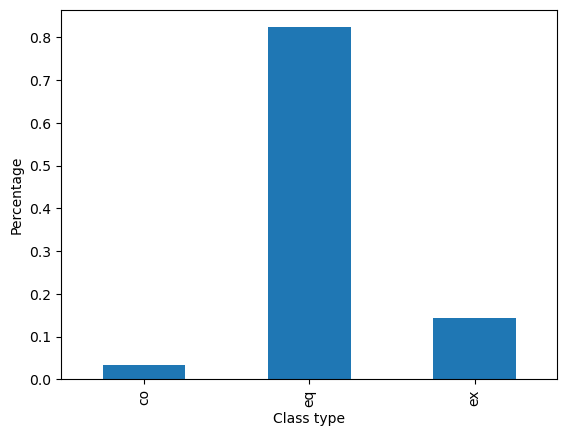

In [9]:
# Class imbalance: 
# Earthquakes   82.4% 
# Explosions    14.3% 
# Mine Collapses 3.3%  
#
print(len(df), df.shape)
classes = df.groupby("etype")['etype'].count()/len(df)
print(type(classes))
print(classes)
classes.plot.bar(x="etype")
plt.ylabel("Percentage")
plt.xlabel("Class type")
plt.show()

Statistical distribution of important numerical values

In [10]:
df[['lune_lat', 'lune_lon', 'mxx', 'myy', 'mzz', 'mxy', 'mxz', 'myz', 'eig1', 'eig2', 'eig3']].describe()

,lune_lat,lune_lon,mxx,myy,mzz,mxy,mxz,myz,eig1,eig2,eig3
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,10.608643,-1.619871,-0.113497,0.358150,0.068749,-0.034449,-0.017982,0.023640,0.098059,0.121860,0.093487
std,29.939273,11.517958,0.518404,0.457696,0.512899,0.366938,0.252813,0.233605,0.677011,0.468342,0.828708
min,-77.960000,-29.814200,-0.991400,-0.994300,-0.998900,-0.929700,-0.941800,-0.798800,-1.000000,-1.000000,-1.000000
25%,-6.818300,-7.996700,-0.540075,0.095588,-0.251675,-0.283475,-0.167525,-0.116825,-0.527575,-0.158375,-0.797150
50%,7.934650,-0.758100,-0.158300,0.432150,0.048325,-0.031360,-0.000499,0.028235,0.158950,0.113800,0.225250
75%,24.937625,5.026025,0.308025,0.728150,0.393650,0.157750,0.134425,0.165425,0.751800,0.382650,0.999775
max,82.448800,29.615600,0.999900,0.999000,0.999800,0.958300,0.904900,0.807200,1.000000,1.000000,1.000000


We computed the correlation between input parameters.  We observed moderate 0.5 negative correlations between lune_lat, lune_lon, and the diagonal of the moment tensor (mxx,myy,mzz). This is expected since the values are derived from each other.  Eig1 and Eig3 is negatively correlate because pure double couple earthquakes are represented by eigenvalues (-1, 0, +1). 

          lune_lat  lune_lon       mxx       myy       mzz       mxy  \
lune_lat  1.000000 -0.459587  0.550022  0.435176  0.754010  0.045509   
lune_lon -0.459587  1.000000 -0.232788 -0.249745 -0.285798 -0.048021   
mxx       0.550022 -0.232788  1.000000 -0.254752  0.164654  0.147961   
myy       0.435176 -0.249745 -0.254752  1.000000  0.116550 -0.079628   
mzz       0.754010 -0.285798  0.164654  0.116550  1.000000  0.006854   
mxy       0.045509 -0.048021  0.147961 -0.079628  0.006854  1.000000   
mxz       0.021380 -0.031909 -0.087389  0.099669  0.028073  0.006783   
myz      -0.049812 -0.023037 -0.063864  0.025519 -0.048824 -0.000711   
eig1      0.351039 -0.003108  0.303047  0.264437  0.064692 -0.035807   
eig2      0.474907  0.070986  0.382219  0.239448  0.222219  0.037882   
eig3      0.495914 -0.498022  0.123179  0.113722  0.607850  0.060665   
label     0.177268 -0.049500  0.213778 -0.131781  0.190795  0.015843   

               mxz       myz      eig1      eig2      eig3     

<AxesSubplot:>

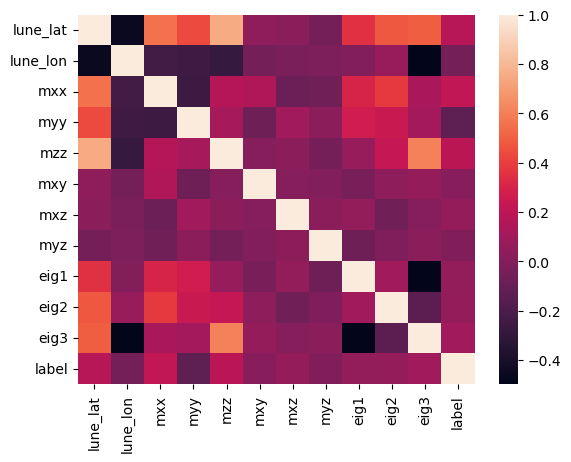

In [11]:
cor = df[['lune_lat', 'lune_lon', 
          'mxx', 'myy', 'mzz', 'mxy', 'mxz', 'myz', 
          'eig1', 'eig2', 'eig3', 
          'label']].corr()
print(cor)
sns.heatmap(cor)

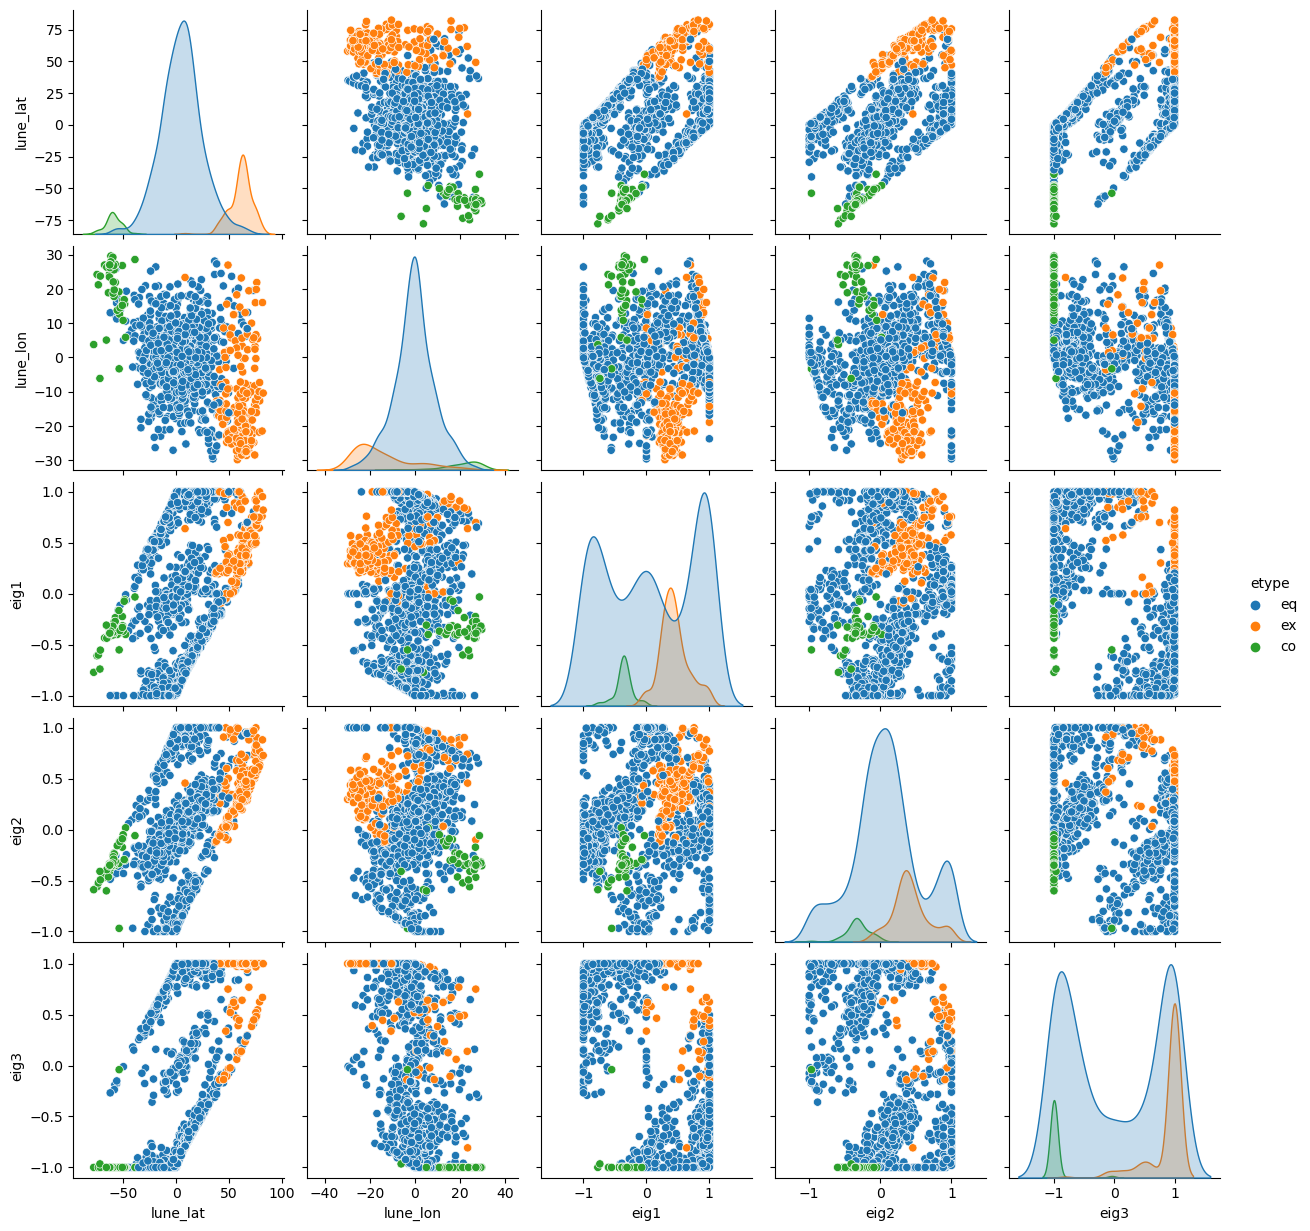

In [12]:
sns.pairplot( data = df[['lune_lat', 'lune_lon', 'eig1', 'eig2', 'eig3', 'etype']], hue='etype' )

These two values are derived from eigenvalues in sperhical coordinate system. These are the best set to use in training a classifier. 

<AxesSubplot:xlabel='lune_lon', ylabel='lune_lat'>

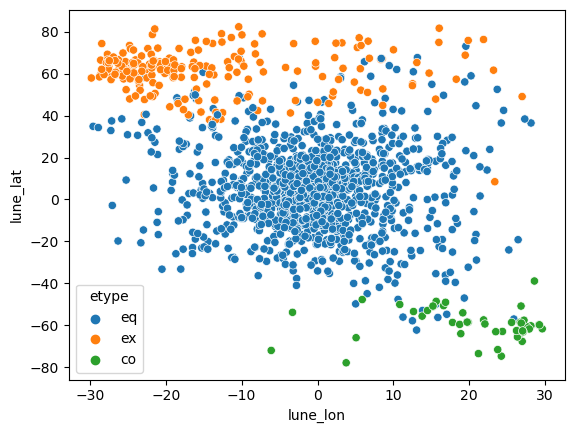

In [13]:
sns.scatterplot( data=df, y='lune_lat', x='lune_lon', hue='etype')

The most logical approach was to classify using just lune_lat and lune_lon. Here we set the X,y input independent variables and target labels.   

In [14]:
### We iterated with 3 sets of features.  The first two sets did not do well.  
### The most logical approach was to classify using just lune_lat and lune_lon
#
features = ['lune_lat', 'lune_lon']
X_orig = df[features]
y =  df[['label']]

Since the dataset is small (1400 values), then we made a larger 40% test set. 

In [15]:
X_train, X_test, y_train, y_test = train_test_split( X_orig, y, test_size=0.4, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(864, 2)
(576, 2)
(864, 1)
(576, 1)


# Support Vector Machine Classifier (SVC)

The SVM is a supervised learning model that discovers the best fitting maximum margins between data labeled categories from the marginal points rather than directly using the statistical properties of the entire dataset (e.g., mean and covariance of each category).  SVM does linear classification, however kernels can be used for nonlinear classification (nth degree polynomials and Gaussian kernels) for higher dimensional space.


The hyperparameters used were radial basis function, C, and gaama.  The polynomial kernel and associated degree parameters was examined initially and found to perform poorly compared to RBF kernel. The linear kernel was also found to be inferrior to RBF kernels. 

### We used the same setup for testing each classifier.  The pipe line uses a Standard Scaler and then the grid search uses 5-fold cross validation.  The scoring uses the balanced accuracy best for imbalanced datasets. 

In [16]:
svc_clf = OneVsRestClassifier(SVC(probability=True, class_weight='balanced'))

svc_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', svc_clf ) 
])

# "svc__estimator__kernel" : [ 'rbf', 'poly' ]
# "svc__estimator__degree" : [ 1, 2, 3, 4 ],
#  "svc__estimator__gamma"  : [  0.001, 0.01, 0.1, 0.3, 1, 3, 10, 30, 100, 300 ],

params_svc = {
    "svc__estimator__C"      : [ 0.01, 0.1, 1, 10, 30, 100, 300 ], 
    "svc__estimator__gamma"  : [ 0.001, 0.01, 0.1, 1, 10 ],
    "svc__estimator__kernel" : [ 'rbf' ]
}

In [17]:
svc_grid = GridSearchCV( svc_pipe, param_grid=params_svc, cv=5, scoring='balanced_accuracy', verbose=1)
svc_grid.fit( X_train, y_train )
print(svc_grid.best_estimator_)
print(f'best param={svc_grid.best_params_}  best score={svc_grid.best_score_:.3f}')

filename = 'output/svc_grid.sav'
pickle.dump(svc_grid, open(filename,'wb'))

Fitting 5 folds for each of 35 candidates, totalling 175 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 OneVsRestClassifier(estimator=SVC(C=30,
                                                   class_weight='balanced',
                                                   gamma=0.01,
                                                   probability=True)))])
best param={'svc__estimator__C': 30, 'svc__estimator__gamma': 0.01, 'svc__estimator__kernel': 'rbf'}  best score=0.980


Save the classifier model to a file so it can be loaded later for making predictions on a random grid of points that can be contoured for visualizing the decsion boundaries. 

Run the function make_multiclass_score() using the classifier and return a Dataframe populated the classifiers performance metrics using the validation test dataset.  

In [18]:
# Save the estimator for later classification predictions
#
filename = 'output/svc_grid.sav'
load_svc_grid = pickle.load(open(filename, 'rb'))

# Compute the scores macro averages and one-vs-rest class scores
#
df_scores = make_multiclass_score( load_svc_grid, X_train, y_train, X_test, y_test, "SVC" )
df_scores

[[432  26   6]
 [  3  83   0]
 [  0   0  26]]
   eq   ex  co
FP: [ 3 26  6] = [435 109  32] - [432  83  26] off-diagonal columns
FN: [32  3  0] = [464  86  26] - [432  83  26] off-diagonal rows
TP: [432  83  26] = [432  83  26]  diagonal
TN: [109 464 544] = 576 - [ 3 26  6] - [32  3  0] - [432  83  26]
TPR [0.93103448 0.96511628 1.        ] = [432.  83.  26.]/([432.  83.  26.]+[32.  3.  0.]) sensitivity, hit-rate, recall
TPR [0.97321429 0.94693878 0.98909091] = [109. 464. 544.]/([109. 464. 544.]+[ 3. 26.  6.]) specificity
PPV [0.99310345 0.76146789 0.8125    ] = [432.  83.  26.]/([432.  83.  26.]+[ 3. 26.  6.]) Precision
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC [0.93923611 0.94965278 0.98958333] = ([432.  83.  26.]+[109. 464. 544.])/([432.  83.  26.]+[ 3. 26.  6.]+[32.  3.  0.]+[109. 464. 544.]) accuracy
Balanced Accuracy = [0.95212438 0.95602753 0.99454545]
accuracy [0.93923611 0.94965278 0.98958333]
precision [0.99310345 0.76146789 0.8125    ]
sensitivity/recall [0.93103448 0.96511628 1.     

,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
0,SVC,0.98,0.939,0.856,0.965,0.903,0.987,0.129


Create plots for the Confusion Matrix, ROC curves, and Precision-Recall Curves for classifiers with decsion_functions()

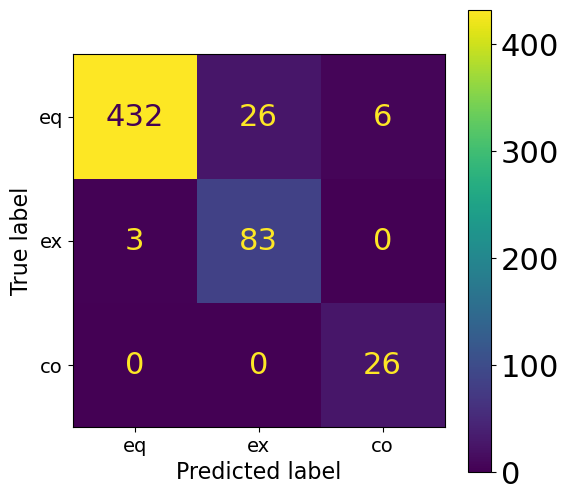

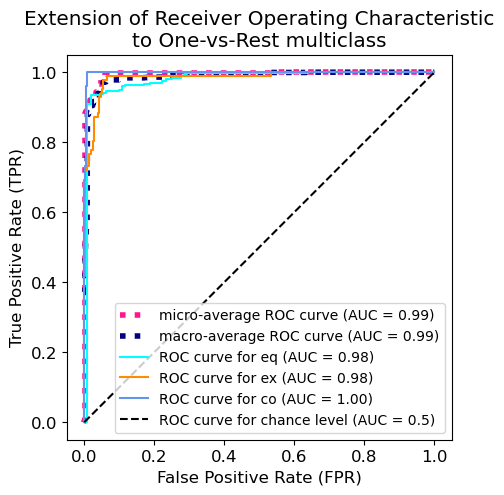

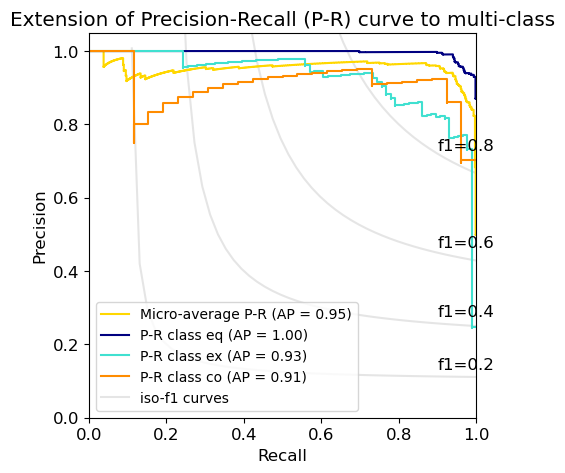

In [19]:
# Create Confusion Matrix, ROC curves, and Precision-Recall Curves
#
class_labels = ['eq', 'ex', 'co']

multiclass_confusion_matrix( load_svc_grid, class_labels, X_test, y_test )

multiclass_roc_curves( load_svc_grid, class_labels, X_train, y_train, X_test, y_test )

multiclass_precision_recall( load_svc_grid, class_labels, X_train, y_train, X_test, y_test )

# Decision Tree Classifier (DTC)

The decsion tree classifier is a supervised learning algorithm that uses a set of rules to make decsion boundaries.   At each node there is a yes or no question and the creating branches and segmenting rectangular regions of the feature space.  The subsequent tree nodes are repeatly split until the node is "pure" all of the same class.  The goal is to do this with the least complex tree and fewest splits. 

We did a grid search using both Gini impurity and Entropy are a metric of chaos within the nodes as a loss function to minimize.  Several inital runs were performed to settle on these set of best hyperparameters to search for.      

### We used the same setup for testing each classifier.  The pipe line uses a Standard Scaler and then the grid search uses 5-fold cross validation.  The scoring uses the balanced accuracy best for imbalanced datasets.  

In [20]:
dtc_clf = OneVsRestClassifier(DecisionTreeClassifier(class_weight="balanced"))

dtc_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('dtc', dtc_clf ) 
])

params_dtc = {
    "dtc__estimator__ccp_alpha" : [ 0.001, 0.003, 0.01, 0.03, 0.1 ],
    "dtc__estimator__criterion" : [ "gini", "entropy" ],
    "dtc__estimator__max_depth"  :        [ 10, 20, 40 ],
    "dtc__estimator__min_samples_split" : [ 2, 3, 4, 5 ],
    "dtc__estimator__splitter" : [ "best", "random" ]
}
# best param={
#   'dtc__estimator__ccp_alpha': 0.01, 
#   'dtc__estimator__criterion': 'gini', 
#   'dtc__estimator__max_depth': 20, 
#   'dtc__estimator__min_samples_split': 3, 
#   'dtc__estimator__splitter': 'random'}  best score=0.939

In [21]:
dtc_grid = GridSearchCV( dtc_pipe, param_grid=params_dtc, cv=5, scoring='balanced_accuracy', verbose=1)
dtc_grid.fit( X_train, y_train )
print(dtc_grid.best_estimator_)
print(f'best param={dtc_grid.best_params_}  best score={dtc_grid.best_score_:.3f}')

filename = 'output/dtc_grid.sav'
pickle.dump(dtc_grid, open(filename,'wb'))

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('dtc',
                 OneVsRestClassifier(estimator=DecisionTreeClassifier(ccp_alpha=0.003,
                                                                      class_weight='balanced',
                                                                      max_depth=10,
                                                                      min_samples_split=3,
                                                                      splitter='random')))])
best param={'dtc__estimator__ccp_alpha': 0.003, 'dtc__estimator__criterion': 'gini', 'dtc__estimator__max_depth': 10, 'dtc__estimator__min_samples_split': 3, 'dtc__estimator__splitter': 'random'}  best score=0.982


In [22]:
# Save the estimator for later classification predictions
#
filename = 'output/dtc_grid.sav'
load_dtc_grid = pickle.load(open(filename, 'rb'))

# Compute the scores macro averages and one-vs-rest class scores
#
df_tmp = make_multiclass_score( load_dtc_grid, X_train, y_train, X_test, y_test, "DTC" )
df_scores = pd.concat( [df_tmp, df_scores] )
df_scores

[[436  22   6]
 [  3  82   1]
 [  0   0  26]]
   eq   ex  co
FP: [ 3 22  7] = [439 104  33] - [436  82  26] off-diagonal columns
FN: [28  4  0] = [464  86  26] - [436  82  26] off-diagonal rows
TP: [436  82  26] = [436  82  26]  diagonal
TN: [109 468 543] = 576 - [ 3 22  7] - [28  4  0] - [436  82  26]
TPR [0.93965517 0.95348837 1.        ] = [436.  82.  26.]/([436.  82.  26.]+[28.  4.  0.]) sensitivity, hit-rate, recall
TPR [0.97321429 0.95510204 0.98727273] = [109. 468. 543.]/([109. 468. 543.]+[ 3. 22.  7.]) specificity
PPV [0.99316629 0.78846154 0.78787879] = [436.  82.  26.]/([436.  82.  26.]+[ 3. 22.  7.]) Precision
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC [0.94618056 0.95486111 0.98784722] = ([436.  82.  26.]+[109. 468. 543.])/([436.  82.  26.]+[ 3. 22.  7.]+[28.  4.  0.]+[109. 468. 543.]) accuracy
Balanced Accuracy = [0.95643473 0.95429521 0.99363636]
accuracy [0.94618056 0.95486111 0.98784722]
precision [0.99316629 0.78846154 0.78787879]
sensitivity/recall [0.93965517 0.95348837 1.     

,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
0,DTC,0.982,0.944,0.857,0.964,0.903,0.981,0.006
0,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.129


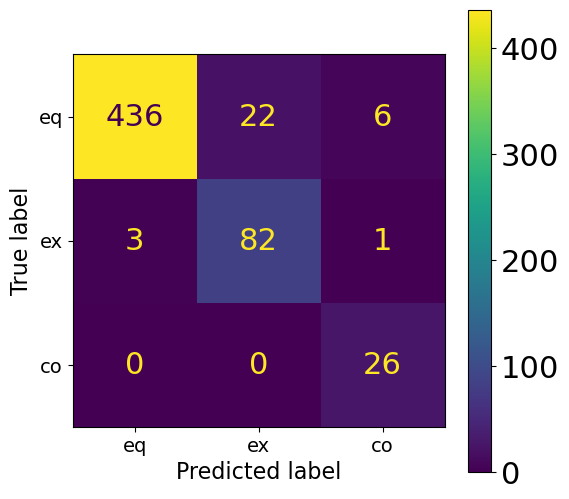

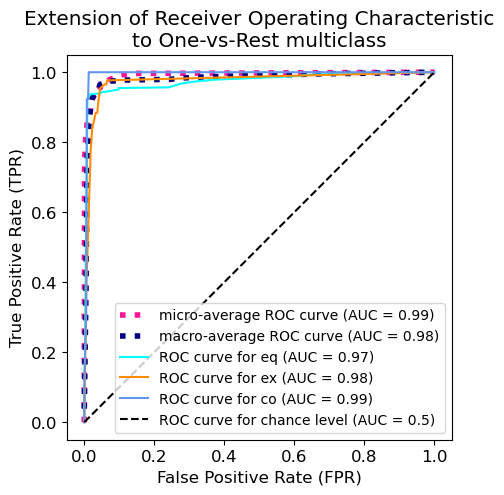

In [23]:
# Create Confusion Matrix, ROC curves, and Precision-Recall Curves
#
class_labels = ['eq', 'ex', 'co']

multiclass_confusion_matrix( load_dtc_grid, class_labels, X_test, y_test )

multiclass_roc_curves( load_dtc_grid, class_labels, X_train, y_train, X_test, y_test )

### DecisionTreeClassifiers do not have a decision_function() method only predict() and predict_proba()
#
# multiclass_precision_recall( load_dtc_grid, class_labels, X_train, y_train, X_test, y_test )

# KNeighborsClassifier (KNN)

The supervised learning approach is non-parameterized and instead training is based on a majority vote of n nearest neighbors. Nearest neighbor rules in effect implicitly compute the decision boundary. 

The hyperparameters are limited to prevent complex classifiers and overfitting. 

### We used the same setup for testing each classifier.  The pipe line uses a Standard Scaler and then the grid search uses 5-fold cross validation.  The scoring uses the balanced accuracy best for imbalanced datasets. 

In [24]:
knn_clf = OneVsRestClassifier(KNeighborsClassifier())

knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', knn_clf ) 
])

params_knn = {
    "knn__estimator__algorithm"  : [  "auto", "ball_tree", "kd_tree", "brute" ],
    "knn__estimator__leaf_size" : [ 1, 2, 3, 4, 5, 6 ],
    "knn__estimator__n_neighbors" : [ 15, 20, 25, 30 ],
    "knn__estimator__weights" : [ "uniform", "distance" ]
}
# best param={'knn__estimator__algorithm': 'auto', 'knn__estimator__leaf_size': 5, 
# 'knn__estimator__n_neighbors': 10, 'knn__estimator__weights': 'distance'}  best score=0.861

In [25]:
knn_grid = GridSearchCV( knn_pipe, param_grid=params_knn, cv=5, scoring='balanced_accuracy', verbose=1)
knn_grid.fit( X_train, y_train )
print( knn_grid.best_estimator_)
print(f'best param={knn_grid.best_params_}  best score={knn_grid.best_score_:.3f}')

filename = 'output/knn_grid.sav'
pickle.dump(knn_grid, open(filename,'wb'))

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 OneVsRestClassifier(estimator=KNeighborsClassifier(leaf_size=1,
                                                                    n_neighbors=15,
                                                                    weights='distance')))])
best param={'knn__estimator__algorithm': 'auto', 'knn__estimator__leaf_size': 1, 'knn__estimator__n_neighbors': 15, 'knn__estimator__weights': 'distance'}  best score=0.920


In [26]:
# Save the estimator for later classification predictions
#
filename = 'output/knn_grid.sav'
load_knn_grid = pickle.load(open(filename, 'rb'))

# Compute the scores macro averages and one-vs-rest class scores
#
df_tmp = make_multiclass_score( load_knn_grid, X_train, y_train, X_test, y_test, "KNN" )
df_scores = pd.concat( [df_tmp, df_scores] )
df_scores

[[450  11   3]
 [ 21  65   0]
 [  4   0  22]]
   eq   ex  co
FP: [25 11  3] = [475  76  25] - [450  65  22] off-diagonal columns
FN: [14 21  4] = [464  86  26] - [450  65  22] off-diagonal rows
TP: [450  65  22] = [450  65  22]  diagonal
TN: [ 87 479 547] = 576 - [25 11  3] - [14 21  4] - [450  65  22]
TPR [0.96982759 0.75581395 0.84615385] = [450.  65.  22.]/([450.  65.  22.]+[14. 21.  4.]) sensitivity, hit-rate, recall
TPR [0.77678571 0.97755102 0.99454545] = [ 87. 479. 547.]/([ 87. 479. 547.]+[25. 11.  3.]) specificity
PPV [0.94736842 0.85526316 0.88      ] = [450.  65.  22.]/([450.  65.  22.]+[25. 11.  3.]) Precision
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC [0.93229167 0.94444444 0.98784722] = ([450.  65.  22.]+[ 87. 479. 547.])/([450.  65.  22.]+[25. 11.  3.]+[14. 21.  4.]+[ 87. 479. 547.]) accuracy
Balanced Accuracy = [0.87330665 0.86668249 0.92034965]
accuracy [0.93229167 0.94444444 0.98784722]
precision [0.94736842 0.85526316 0.88      ]
sensitivity/recall [0.96982759 0.75581395 0.84615

,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
0,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005
0,DTC,0.982,0.944,0.857,0.964,0.903,0.981,0.006
0,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.129


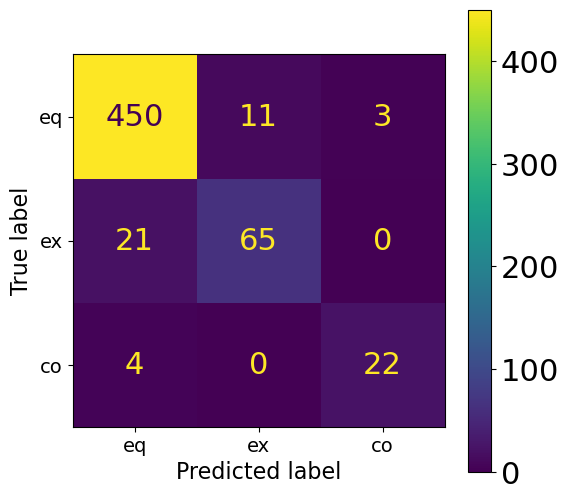

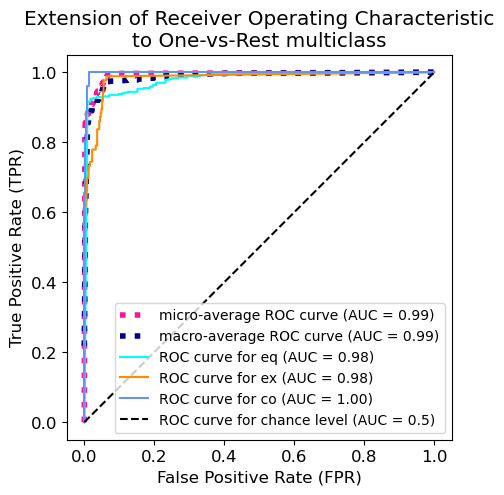

In [27]:
# Create Confusion Matrix, ROC curves, and Precision-Recall Curves
#
class_labels = ['eq', 'ex', 'co']

multiclass_confusion_matrix( load_knn_grid, class_labels, X_test, y_test )

multiclass_roc_curves( load_knn_grid, class_labels, X_train, y_train, X_test, y_test )

# multiclass_precision_recall( load_knn_grid, class_labels, X_train, y_train, X_test, y_test )

# Logistic Regression Classifier (LGR)

A supervised learning approach is a statistical method finds the best fit logistic function to the independent variables.  This is a linear method meaning that the decision boundaries are limited to linear.  

We tested several solvers and these all work with L2 norm but some do not work with L1 norm.  The C hyperparameter is a complexity parameter and works like inverse of regularization.  

### We used the same setup for testing each classifier.  The pipe line uses a Standard Scaler and then the grid search uses 5-fold cross validation.  The scoring uses the balanced accuracy best for imbalanced datasets.  

In [28]:
lgr_clf = OneVsRestClassifier(LogisticRegression(class_weight="balanced", multi_class='ovr'))

lgr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lgr', lgr_clf ) 
])

#     "lgr__estimator__penalty" : [ "l1", "l2" ],

params_lgr = {
    "lgr__estimator__C" : [ 0.001, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100 ], 
    "lgr__estimator__penalty" : [ "l2" ],
    "lgr__estimator__solver"  : [  "lbfgs", "liblinear", "newton-cg", "sag", "saga" ]
}

In [29]:
lgr_grid = GridSearchCV( lgr_pipe, param_grid=params_lgr, cv=5, scoring='balanced_accuracy', verbose=1)
lgr_grid.fit( X_train, y_train )
print( lgr_grid.best_estimator_)
print(f'best param={lgr_grid.best_params_}  best score={lgr_grid.best_score_:.3f}')

filename = 'output/lgr_grid.sav'
pickle.dump(lgr_grid, open(filename,'wb'))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('lgr',
                 OneVsRestClassifier(estimator=LogisticRegression(C=0.3,
                                                                  class_weight='balanced',
                                                                  multi_class='ovr',
                                                                  solver='saga')))])
best param={'lgr__estimator__C': 0.3, 'lgr__estimator__penalty': 'l2', 'lgr__estimator__solver': 'saga'}  best score=0.968


In [30]:
# Save the estimator for later classification predictions
#
filename = 'output/lgr_grid.sav'
load_lgr_grid = pickle.load(open(filename, 'rb'))

# Compute the scores macro averages and one-vs-rest class scores
#
df_tmp = make_multiclass_score( load_lgr_grid, X_train, y_train, X_test, y_test, "LGR" )
df_scores = pd.concat( [df_tmp, df_scores] )
df_scores

[[412  32  20]
 [  2  84   0]
 [  0   0  26]]
   eq   ex  co
FP: [ 2 32 20] = [414 116  46] - [412  84  26] off-diagonal columns
FN: [52  2  0] = [464  86  26] - [412  84  26] off-diagonal rows
TP: [412  84  26] = [412  84  26]  diagonal
TN: [110 458 530] = 576 - [ 2 32 20] - [52  2  0] - [412  84  26]
TPR [0.88793103 0.97674419 1.        ] = [412.  84.  26.]/([412.  84.  26.]+[52.  2.  0.]) sensitivity, hit-rate, recall
TPR [0.98214286 0.93469388 0.96363636] = [110. 458. 530.]/([110. 458. 530.]+[ 2. 32. 20.]) specificity
PPV [0.99516908 0.72413793 0.56521739] = [412.  84.  26.]/([412.  84.  26.]+[ 2. 32. 20.]) Precision
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC [0.90625    0.94097222 0.96527778] = ([412.  84.  26.]+[110. 458. 530.])/([412.  84.  26.]+[ 2. 32. 20.]+[52.  2.  0.]+[110. 458. 530.]) accuracy
Balanced Accuracy = [0.93503695 0.95571903 0.98181818]
accuracy [0.90625    0.94097222 0.96527778]
precision [0.99516908 0.72413793 0.56521739]
sensitivity/recall [0.88793103 0.97674419 1.     

,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
0,LGR,0.973,0.906,0.762,0.955,0.831,0.971,0.012
0,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005
0,DTC,0.982,0.944,0.857,0.964,0.903,0.981,0.006
0,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.129


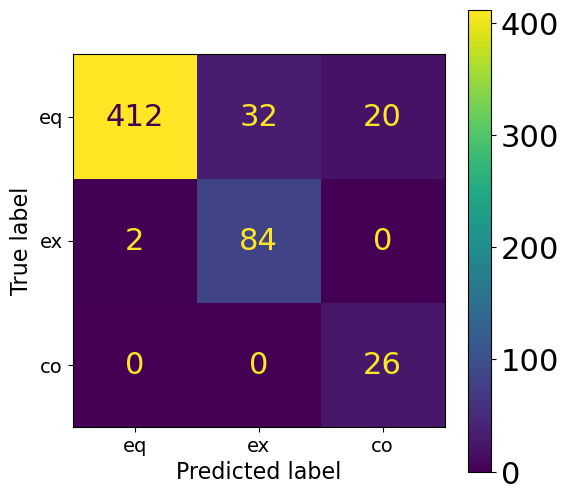

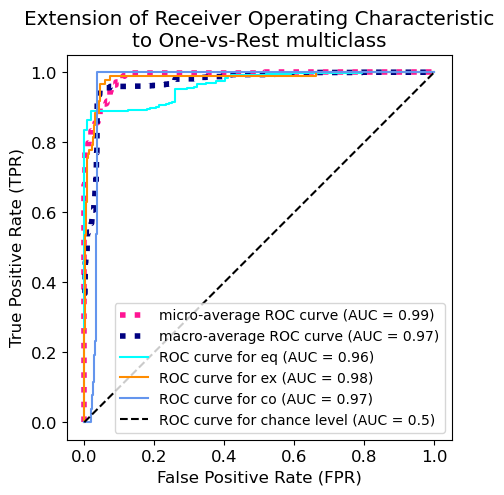

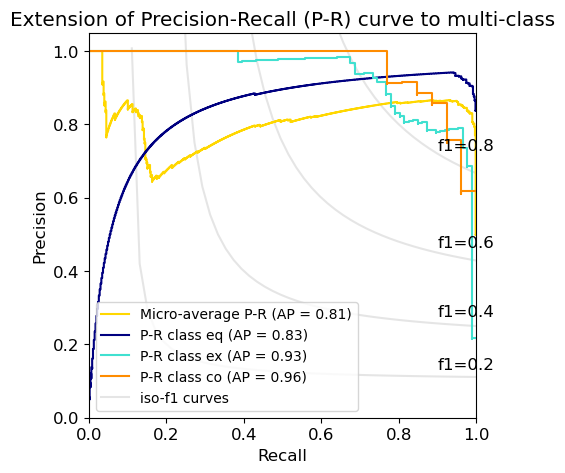

In [31]:
# Create Confusion Matrix, ROC curves, and Precision-Recall Curves
#
class_labels = ['eq', 'ex', 'co']

multiclass_confusion_matrix( load_lgr_grid, class_labels, X_test, y_test )

multiclass_roc_curves( load_lgr_grid, class_labels, X_train, y_train, X_test, y_test )

multiclass_precision_recall( load_lgr_grid, class_labels, X_train, y_train, X_test, y_test )

# Random Forest Classifier (RFC)

This classifier is a supervised learning method that uses a number of decision trees as an ensemble. A large number of relatively uncorrelated models operating as a crowd (wisdom of the crowd) outperforms individual models.   


### We used the same setup for testing each classifier.  The pipe line uses a Standard Scaler and then the grid search uses 5-fold cross validation.  The scoring uses the balanced accuracy best for imbalanced datasets.  

In [32]:
rfc_clf = OneVsRestClassifier(RandomForestClassifier(class_weight="balanced"))

rfc_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rfc', rfc_clf ) 
])

params_rfc = {
    "rfc__estimator__ccp_alpha" : [ 0.001, 0.003, 0.01, 0.03, 0.1 ],
    "rfc__estimator__criterion" : [ "gini" ], 
    "rfc__estimator__max_depth"  : [ 10, 20, 40 ],
    "rfc__estimator__min_samples_split" : [ 2, 3, 4 ],
    "rfc__estimator__n_estimators" : [ 100, 200 ]
}

# best param={
# 'rfc__estimator__ccp_alpha': 0.01, 'rfc__estimator__criterion': 'gini', 
# 'rfc__estimator__max_depth': 10, 'rfc__estimator__min_samples_split': 3, 
# 'rfc__estimator__n_estimators': 100}  best score=0.929


In [33]:
rfc_grid = GridSearchCV( rfc_pipe, param_grid=params_rfc, cv=5, scoring='balanced_accuracy', verbose=1)
rfc_grid.fit( X_train, y_train )
print( rfc_grid.best_estimator_)
print(f'best param={rfc_grid.best_params_}  best score={rfc_grid.best_score_:.3f}')

filename = 'output/rfc_grid.sav'
pickle.dump(rfc_grid, open(filename,'wb'))

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('rfc',
                 OneVsRestClassifier(estimator=RandomForestClassifier(ccp_alpha=0.1,
                                                                      class_weight='balanced',
                                                                      max_depth=40,
                                                                      min_samples_split=4)))])
best param={'rfc__estimator__ccp_alpha': 0.1, 'rfc__estimator__criterion': 'gini', 'rfc__estimator__max_depth': 40, 'rfc__estimator__min_samples_split': 4, 'rfc__estimator__n_estimators': 100}  best score=0.963


In [34]:
filename = 'output/rfc_grid.sav'
load_rfc_grid = pickle.load(open(filename, 'rb'))

df_tmp = make_multiclass_score( load_rfc_grid, X_train, y_train, X_test, y_test, "RFC" )

df_scores = pd.concat( [df_tmp, df_scores] )
df_scores

[[435  25   4]
 [  4  82   0]
 [  1   0  25]]
   eq   ex  co
FP: [ 5 25  4] = [440 107  29] - [435  82  25] off-diagonal columns
FN: [29  4  1] = [464  86  26] - [435  82  25] off-diagonal rows
TP: [435  82  25] = [435  82  25]  diagonal
TN: [107 465 546] = 576 - [ 5 25  4] - [29  4  1] - [435  82  25]
TPR [0.9375     0.95348837 0.96153846] = [435.  82.  25.]/([435.  82.  25.]+[29.  4.  1.]) sensitivity, hit-rate, recall
TPR [0.95535714 0.94897959 0.99272727] = [107. 465. 546.]/([107. 465. 546.]+[ 5. 25.  4.]) specificity
PPV [0.98863636 0.76635514 0.86206897] = [435.  82.  25.]/([435.  82.  25.]+[ 5. 25.  4.]) Precision
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC [0.94097222 0.94965278 0.99131944] = ([435.  82.  25.]+[107. 465. 546.])/([435.  82.  25.]+[ 5. 25.  4.]+[29.  4.  1.]+[107. 465. 546.]) accuracy
Balanced Accuracy = [0.94642857 0.95123398 0.97713287]
accuracy [0.94097222 0.94965278 0.99131944]
precision [0.98863636 0.76635514 0.86206897]
sensitivity/recall [0.9375     0.95348837 0.96153

,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
0,RFC,0.968,0.941,0.872,0.951,0.907,0.984,0.458
0,LGR,0.973,0.906,0.762,0.955,0.831,0.971,0.012
0,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005
0,DTC,0.982,0.944,0.857,0.964,0.903,0.981,0.006
0,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.129


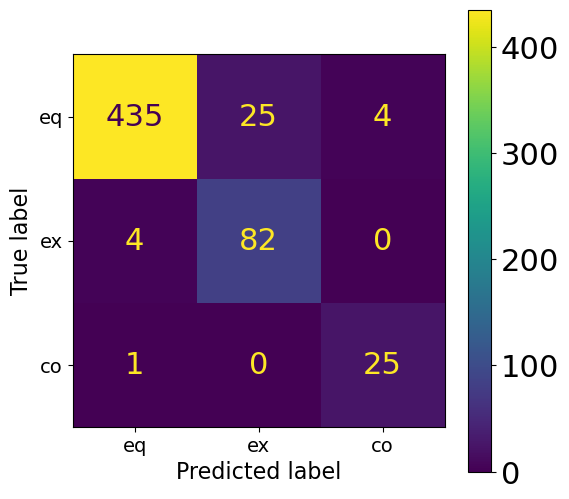

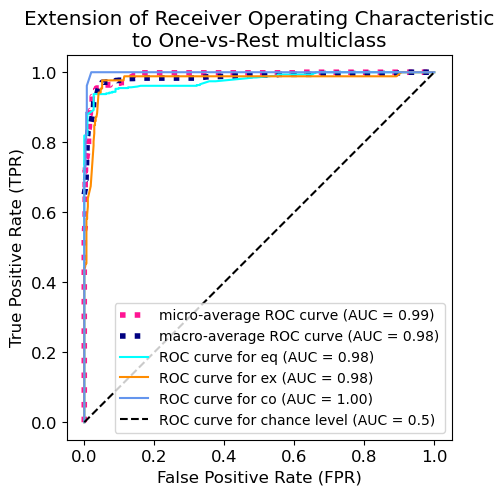

In [35]:
class_labels = ['eq', 'ex', 'co']

multiclass_confusion_matrix( load_rfc_grid, class_labels, X_test, y_test )

multiclass_roc_curves( load_rfc_grid, class_labels, X_train, y_train, X_test, y_test )

# multiclass_precision_recall( load_rfc_grid, class_labels, X_train, y_train, X_test, y_test )

# Gaussian Process Classifier (GPC)

This is a supervised learning non parameterized algorithm based on Gaussian probability distribution similar to SVM.  There is one hyperparameter "kernel" to tune and default values are used for the rest.  

### We used the same setup for testing each classifier.  The pipe line uses a Standard Scaler and then the grid search uses 5-fold cross validation.  The scoring uses the balanced accuracy best for imbalanced datasets.  

In [36]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel

gpc_clf = OneVsRestClassifier(GaussianProcessClassifier(multi_class="one_vs_rest"))

gpc_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('gpc', gpc_clf ) 
])

params_gpc = { "gpc__estimator__kernel" : [1*RBF(), 1*DotProduct(), 1*Matern(),  1*RationalQuadratic(), 1*WhiteKernel()], }

In [37]:
gpc_grid = GridSearchCV( gpc_pipe, param_grid=params_gpc, cv=5, scoring='balanced_accuracy', verbose=3)
gpc_grid.fit( X_train, y_train )
print( gpc_grid.best_estimator_)
print(f'best param={gpc_grid.best_params_}  best score={gpc_grid.best_score_:.3f}')

filename = 'output/gpc_grid.sav'
pickle.dump(gpc_grid, open(filename,'wb'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END gpc__estimator__kernel=1**2 * RBF(length_scale=1);, score=0.803 total time=  13.3s
[CV 2/5] END gpc__estimator__kernel=1**2 * RBF(length_scale=1);, score=0.977 total time=  12.1s
[CV 3/5] END gpc__estimator__kernel=1**2 * RBF(length_scale=1);, score=0.951 total time=  11.3s
[CV 4/5] END gpc__estimator__kernel=1**2 * RBF(length_scale=1);, score=0.882 total time=  12.2s
[CV 5/5] END gpc__estimator__kernel=1**2 * RBF(length_scale=1);, score=0.785 total time=  12.9s
[CV 1/5] END gpc__estimator__kernel=1**2 * DotProduct(sigma_0=1);, score=nan total time=   2.5s
[CV 2/5] END gpc__estimator__kernel=1**2 * DotProduct(sigma_0=1);, score=nan total time=   2.5s
[CV 3/5] END gpc__estimator__kernel=1**2 * DotProduct(sigma_0=1);, score=nan total time=   2.4s
[CV 4/5] END gpc__estimator__kernel=1**2 * DotProduct(sigma_0=1);, score=nan total time=   3.1s
[CV 5/5] END gpc__estimator__kernel=1**2 * DotProduct(sigma_0=1);, score=nan

In [38]:
filename = 'output/gpc_grid.sav'
load_gpc_grid = pickle.load(open(filename, 'rb'))

df_tmp = make_multiclass_score( load_gpc_grid, X_train, y_train, X_test, y_test, "GPC" )

df_scores = pd.concat( [df_tmp, df_scores] )
df_scores

[[451  11   2]
 [ 19  67   0]
 [  6   0  20]]
   eq   ex  co
FP: [25 11  2] = [476  78  22] - [451  67  20] off-diagonal columns
FN: [13 19  6] = [464  86  26] - [451  67  20] off-diagonal rows
TP: [451  67  20] = [451  67  20]  diagonal
TN: [ 87 479 548] = 576 - [25 11  2] - [13 19  6] - [451  67  20]
TPR [0.97198276 0.77906977 0.76923077] = [451.  67.  20.]/([451.  67.  20.]+[13. 19.  6.]) sensitivity, hit-rate, recall
TPR [0.77678571 0.97755102 0.99636364] = [ 87. 479. 548.]/([ 87. 479. 548.]+[25. 11.  2.]) specificity
PPV [0.94747899 0.85897436 0.90909091] = [451.  67.  20.]/([451.  67.  20.]+[25. 11.  2.]) Precision
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC [0.93402778 0.94791667 0.98611111] = ([451.  67.  20.]+[ 87. 479. 548.])/([451.  67.  20.]+[25. 11.  2.]+[13. 19.  6.]+[ 87. 479. 548.]) accuracy
Balanced Accuracy = [0.87438424 0.87831039 0.8827972 ]
accuracy [0.93402778 0.94791667 0.98611111]
precision [0.94747899 0.85897436 0.90909091]
sensitivity/recall [0.97198276 0.77906977 0.76923

,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
0,GPC,0.902,0.934,0.905,0.840,0.870,0.990,14.395
0,RFC,0.968,0.941,0.872,0.951,0.907,0.984,0.458
0,LGR,0.973,0.906,0.762,0.955,0.831,0.971,0.012
0,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005
0,DTC,0.982,0.944,0.857,0.964,0.903,0.981,0.006
0,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.129


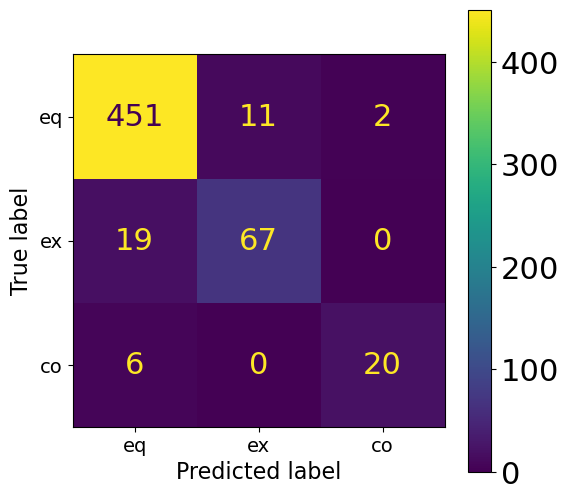

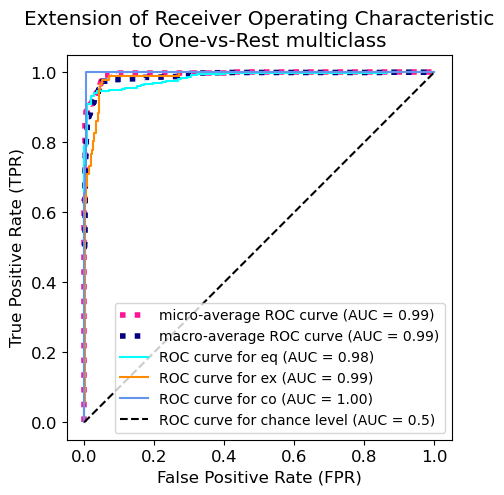

In [39]:
class_labels = ['eq', 'ex', 'co']

multiclass_confusion_matrix( load_gpc_grid, class_labels, X_test, y_test )

multiclass_roc_curves( load_gpc_grid, class_labels, X_train, y_train, X_test, y_test )

# multiclass_precision_recall( load_gpc_grid, class_labels, X_train, y_train, X_test, y_test )

# Multi Layer Perceptron Classifier (MLP)

This is similar to ANN method that we tested in separete Jupyter notebook. 

### We used the same setup for testing each classifier.  The pipe line uses a Standard Scaler and then the grid search uses 5-fold cross validation.  The scoring uses the balanced accuracy best for imbalanced datasets.  

In [40]:
#Multilayer Perceptron classifier
mlp_clf = OneVsRestClassifier(MLPClassifier(max_iter=100, random_state=42))

mlp_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', mlp_clf ) 
])

# "mlp__estimator__activation" : [ "identity", "logistic", "tanh", "relu" ],
# "mlp__estimator__learning_rate" : [ "constant", "invscaling", "adaptive" ],
# "mlp__estimator__hidden_layer_sizes" : [ 100, 300, 1000 ],
# "mlp__estimator__alpha" : [ 0.01, 0.1, 0.3, 1, 3, 10, 100 ],
# "mlp__estimator__learning_rate_init" : [ 0.001, 0.01, 0.1 ]
#
params_mlp = { 
    "mlp__estimator__activation" : [  "tanh" ],
    "mlp__estimator__alpha" : [  0.01, 0.1, 1, 10 ],
    "mlp__estimator__hidden_layer_sizes" : [ 50, 100, 200 ],
    "mlp__estimator__learning_rate" : [ "adaptive" ],
    "mlp__estimator__learning_rate_init" : [ 0.001, 0.01 ],
    "mlp__estimator__solver" : [ "adam" ]
}

In [41]:
mlp_grid = GridSearchCV( mlp_pipe, param_grid=params_mlp, cv=5, scoring='balanced_accuracy', verbose=1)
mlp_grid.fit( X_train, y_train )
print( mlp_grid.best_estimator_)
print(f'best param={mlp_grid.best_params_}  best score={mlp_grid.best_score_:.3f}')

filename = 'output/mlp_grid.sav'
pickle.dump(mlp_grid, open(filename,'wb'))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 OneVsRestClassifier(estimator=MLPClassifier(activation='tanh',
                                                             alpha=0.1,
                                                             hidden_layer_sizes=100,
                                                             learning_rate='adaptive',
                                                             learning_rate_init=0.01,
                                                             max_iter=100,
                                                             random_state=42)))])
best param={'mlp__estimator__activation': 'tanh', 'mlp__estimator__alpha': 0.1, 'mlp__estimator__hidden_layer_sizes': 100, 'mlp__estimator__learning_rate': 'adaptive', 'mlp__estimator__learning_rate_init': 0.01, 'mlp__estimator__solver': 'adam'}  best score=0.913


In [42]:
filename = 'output/mlp_grid.sav'
load_mlp_grid = pickle.load(open(filename, 'rb'))

df_tmp = make_multiclass_score( load_mlp_grid, X_train, y_train, X_test, y_test, "MLP" )

df_scores = pd.concat( [df_tmp, df_scores] )
df_scores

[[450  12   2]
 [ 17  69   0]
 [  6   0  20]]
   eq   ex  co
FP: [23 12  2] = [473  81  22] - [450  69  20] off-diagonal columns
FN: [14 17  6] = [464  86  26] - [450  69  20] off-diagonal rows
TP: [450  69  20] = [450  69  20]  diagonal
TN: [ 89 478 548] = 576 - [23 12  2] - [14 17  6] - [450  69  20]
TPR [0.96982759 0.80232558 0.76923077] = [450.  69.  20.]/([450.  69.  20.]+[14. 17.  6.]) sensitivity, hit-rate, recall
TPR [0.79464286 0.9755102  0.99636364] = [ 89. 478. 548.]/([ 89. 478. 548.]+[23. 12.  2.]) specificity
PPV [0.95137421 0.85185185 0.90909091] = [450.  69.  20.]/([450.  69.  20.]+[23. 12.  2.]) Precision
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC [0.93576389 0.94965278 0.98611111] = ([450.  69.  20.]+[ 89. 478. 548.])/([450.  69.  20.]+[23. 12.  2.]+[14. 17.  6.]+[ 89. 478. 548.]) accuracy
Balanced Accuracy = [0.88223522 0.88891789 0.8827972 ]
accuracy [0.93576389 0.94965278 0.98611111]
precision [0.95137421 0.85185185 0.90909091]
sensitivity/recall [0.96982759 0.80232558 0.76923

,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
0,MLP,0.886,0.936,0.904,0.847,0.873,0.988,1.340
0,GPC,0.902,0.934,0.905,0.840,0.870,0.990,14.395
0,RFC,0.968,0.941,0.872,0.951,0.907,0.984,0.458
0,LGR,0.973,0.906,0.762,0.955,0.831,0.971,0.012
0,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005
0,DTC,0.982,0.944,0.857,0.964,0.903,0.981,0.006
0,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.129


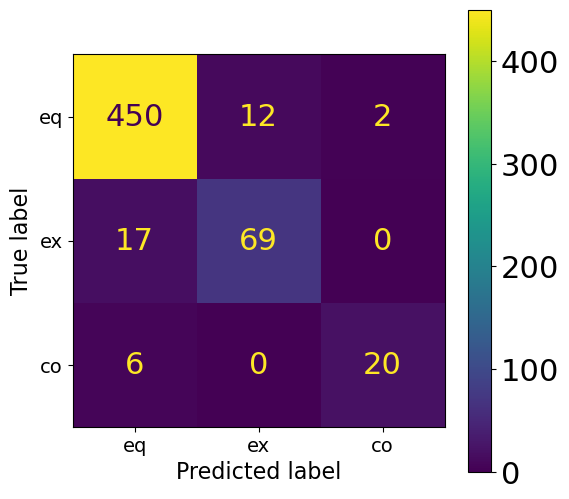

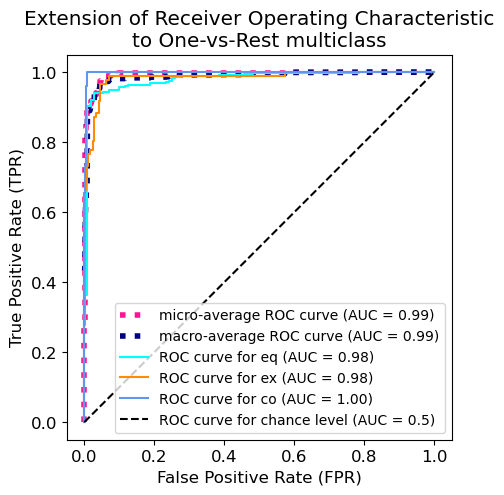

In [43]:
class_labels = ['eq', 'ex', 'co']

multiclass_confusion_matrix( load_mlp_grid, class_labels, X_test, y_test )

multiclass_roc_curves( load_mlp_grid, class_labels, X_train, y_train, X_test, y_test )

# multiclass_precision_recall( load_mlp_grid, class_labels, X_train, y_train, X_test, y_test )

# Ada Boost Classifier (ABC)

This supervised learning method uses an emsemble of weak learners (base estimators - decision stumps).  

### We used the same setup for testing each classifier.  The pipe line uses a Standard Scaler and then the grid search uses 5-fold cross validation.  The scoring uses the balanced accuracy best for imbalanced datasets.  

In [44]:
abc_clf = OneVsRestClassifier(AdaBoostClassifier())

abc_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('abc', abc_clf ) 
])
    
learning_rates = list(np.logspace( -5, -1, 10, base=10, endpoint=True ))
print(f'learning_rates={learning_rates}')

params_abc = {
    "abc__estimator__algorithm" : [ "SAMME", "SAMME.R" ],
    "abc__estimator__learning_rate" : learning_rates,
    "abc__estimator__n_estimators" : [ 1, 2, 4, 8, 12, 16 ]
}

learning_rates=[1e-05, 2.782559402207126e-05, 7.742636826811278e-05, 0.00021544346900318823, 0.0005994842503189409, 0.0016681005372000592, 0.004641588833612777, 0.012915496650148827, 0.03593813663804626, 0.1]


In [45]:
abc_grid = GridSearchCV( abc_pipe, param_grid=params_abc, cv=5, scoring='balanced_accuracy', verbose=1)
abc_grid.fit( X_train, y_train )
print( abc_grid.best_estimator_)
print(f'best param={abc_grid.best_params_}  best score={abc_grid.best_score_:.3f}')

filename = 'output/abc_grid.sav'
pickle.dump(abc_grid, open(filename,'wb'))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('abc',
                 OneVsRestClassifier(estimator=AdaBoostClassifier(algorithm='SAMME',
                                                                  learning_rate=1e-05,
                                                                  n_estimators=1)))])
best param={'abc__estimator__algorithm': 'SAMME', 'abc__estimator__learning_rate': 1e-05, 'abc__estimator__n_estimators': 1}  best score=0.956


In [46]:
filename = 'output/abc_grid.sav'
load_abc_grid = pickle.load(open(filename, 'rb'))

df_tmp = make_multiclass_score( load_abc_grid, X_train, y_train, X_test, y_test, "ABC" )

df_scores = pd.concat( [df_tmp, df_scores] )
df_scores

[[440  20   4]
 [  8  78   0]
 [  1   0  25]]
   eq   ex  co
FP: [ 9 20  4] = [449  98  29] - [440  78  25] off-diagonal columns
FN: [24  8  1] = [464  86  26] - [440  78  25] off-diagonal rows
TP: [440  78  25] = [440  78  25]  diagonal
TN: [103 470 546] = 576 - [ 9 20  4] - [24  8  1] - [440  78  25]
TPR [0.94827586 0.90697674 0.96153846] = [440.  78.  25.]/([440.  78.  25.]+[24.  8.  1.]) sensitivity, hit-rate, recall
TPR [0.91964286 0.95918367 0.99272727] = [103. 470. 546.]/([103. 470. 546.]+[ 9. 20.  4.]) specificity
PPV [0.97995546 0.79591837 0.86206897] = [440.  78.  25.]/([440.  78.  25.]+[ 9. 20.  4.]) Precision
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC [0.94270833 0.95138889 0.99131944] = ([440.  78.  25.]+[103. 470. 546.])/([440.  78.  25.]+[ 9. 20.  4.]+[24.  8.  1.]+[103. 470. 546.]) accuracy
Balanced Accuracy = [0.93395936 0.93308021 0.97713287]
accuracy [0.94270833 0.95138889 0.99131944]
precision [0.97995546 0.79591837 0.86206897]
sensitivity/recall [0.94827586 0.90697674 0.96153

,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
0,ABC,0.976,0.943,0.879,0.939,0.907,0.948,0.039
0,MLP,0.886,0.936,0.904,0.847,0.873,0.988,1.340
0,GPC,0.902,0.934,0.905,0.840,0.870,0.990,14.395
0,RFC,0.968,0.941,0.872,0.951,0.907,0.984,0.458
0,LGR,0.973,0.906,0.762,0.955,0.831,0.971,0.012
0,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005
0,DTC,0.982,0.944,0.857,0.964,0.903,0.981,0.006
0,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.129


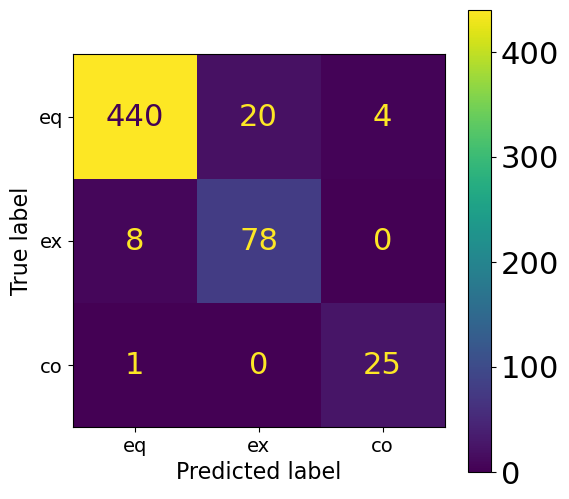

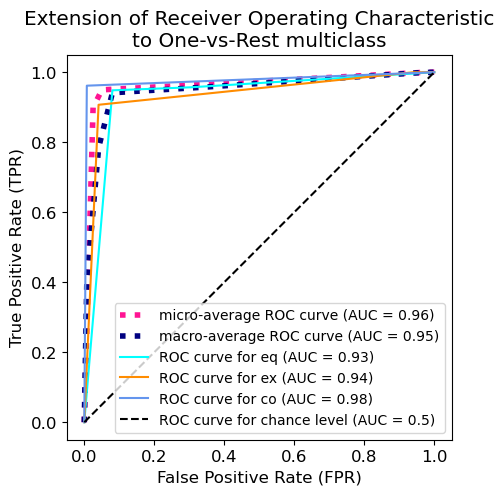

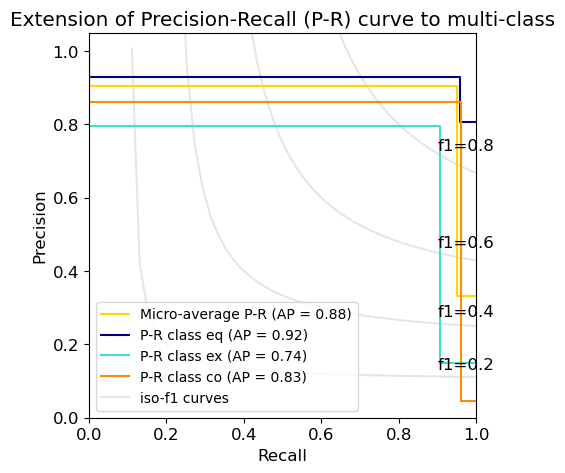

In [47]:
class_labels = ['eq', 'ex', 'co']

multiclass_confusion_matrix( load_abc_grid, class_labels, X_test, y_test )

multiclass_roc_curves( load_abc_grid, class_labels, X_train, y_train, X_test, y_test )

multiclass_precision_recall( load_abc_grid, class_labels, X_train, y_train, X_test, y_test )

# Gaussian Naive Bayes Classifier (GNB)

This is a probabilistic classification algorithm based on Bayes theorem with the assumption that the variables or features are independent of each other. 

### We used the same setup for testing each classifier.  The pipe line uses a Standard Scaler and then the grid search uses 5-fold cross validation.  The scoring uses the balanced accuracy best for imbalanced datasets.  

In [48]:
gnb_clf = OneVsRestClassifier(GaussianNB())

gnb_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('gnb', gnb_clf ) 
])

factors = list(np.logspace( -12, 1, 26, base=10, endpoint=True ))
print(f'smoothing factors={factors}')

params_gnb = {
    "gnb__estimator__var_smoothing" : factors
}

smoothing factors=[1e-12, 3.3113112148259077e-12, 1.0964781961431828e-11, 3.6307805477010174e-11, 1.2022644346174132e-10, 3.9810717055349694e-10, 1.31825673855641e-09, 4.365158322401665e-09, 1.4454397707459279e-08, 4.78630092322638e-08, 1.584893192461114e-07, 5.248074602497734e-07, 1.7378008287493763e-06, 5.754399373371567e-06, 1.9054607179632484e-05, 6.309573444801943e-05, 0.0002089296130854041, 0.0006918309709189362, 0.00229086765276777, 0.0075857757502918515, 0.025118864315095822, 0.08317637711026708, 0.27542287033381746, 0.9120108393559115, 3.019951720402019, 10.0]


In [49]:
# gnb_grid = GridSearchCV( gnb_pipe, param_grid=params_gnb, cv=5, scoring='recall_macro', verbose=1)
gnb_grid = GridSearchCV( gnb_pipe, param_grid=params_gnb, cv=5, scoring='balanced_accuracy', verbose=1)
gnb_grid.fit( X_train, y_train )
print( gnb_grid.best_estimator_)
print(f'best param={gnb_grid.best_params_}  best score={gnb_grid.best_score_:.3f}')

filename = 'output/gnb_grid.sav'
pickle.dump(gnb_grid, open(filename,'wb'))

Fitting 5 folds for each of 26 candidates, totalling 130 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('gnb',
                 OneVsRestClassifier(estimator=GaussianNB(var_smoothing=1e-12)))])
best param={'gnb__estimator__var_smoothing': 1e-12}  best score=0.929


In [50]:
filename = 'output/gnb_grid.sav'
load_gnb_grid = pickle.load(open(filename, 'rb'))

df_tmp = make_multiclass_score( load_gnb_grid, X_train, y_train, X_test, y_test, "GNB" )

df_scores = pd.concat( [df_tmp, df_scores] )
df_scores

[[445  16   3]
 [ 15  71   0]
 [  3   0  23]]
   eq   ex  co
FP: [18 16  3] = [463  87  26] - [445  71  23] off-diagonal columns
FN: [19 15  3] = [464  86  26] - [445  71  23] off-diagonal rows
TP: [445  71  23] = [445  71  23]  diagonal
TN: [ 94 474 547] = 576 - [18 16  3] - [19 15  3] - [445  71  23]
TPR [0.95905172 0.8255814  0.88461538] = [445.  71.  23.]/([445.  71.  23.]+[19. 15.  3.]) sensitivity, hit-rate, recall
TPR [0.83928571 0.96734694 0.99454545] = [ 94. 474. 547.]/([ 94. 474. 547.]+[18. 16.  3.]) specificity
PPV [0.96112311 0.81609195 0.88461538] = [445.  71.  23.]/([445.  71.  23.]+[18. 16.  3.]) Precision
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC [0.93576389 0.94618056 0.98958333] = ([445.  71.  23.]+[ 94. 474. 547.])/([445.  71.  23.]+[18. 16.  3.]+[19. 15.  3.]+[ 94. 474. 547.]) accuracy
Balanced Accuracy = [0.89916872 0.89646417 0.93958042]
accuracy [0.93576389 0.94618056 0.98958333]
precision [0.96112311 0.81609195 0.88461538]
sensitivity/recall [0.95905172 0.8255814  0.88461

,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
0,GNB,0.947,0.936,0.887,0.890,0.889,0.987,0.006
0,ABC,0.976,0.943,0.879,0.939,0.907,0.948,0.039
0,MLP,0.886,0.936,0.904,0.847,0.873,0.988,1.340
0,GPC,0.902,0.934,0.905,0.840,0.870,0.990,14.395
0,RFC,0.968,0.941,0.872,0.951,0.907,0.984,0.458
0,LGR,0.973,0.906,0.762,0.955,0.831,0.971,0.012
0,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005
0,DTC,0.982,0.944,0.857,0.964,0.903,0.981,0.006
0,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.129


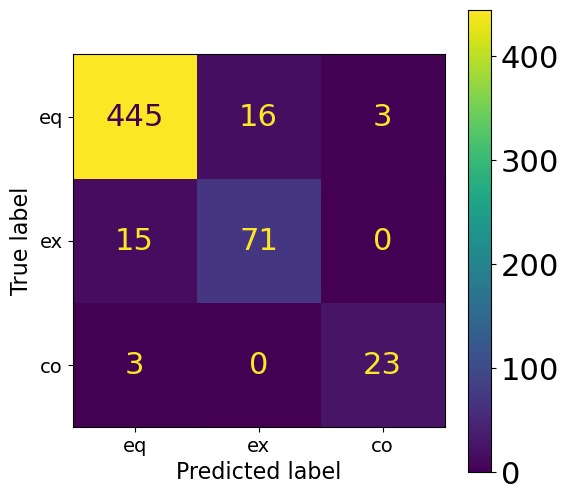

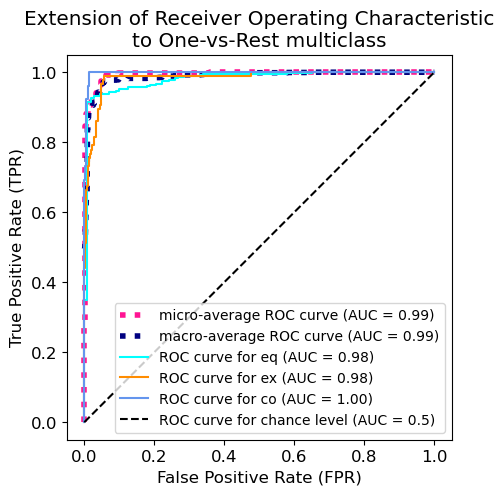

In [51]:
class_labels = ['eq', 'ex', 'co']

multiclass_confusion_matrix( load_gnb_grid, class_labels, X_test, y_test )

multiclass_roc_curves( load_gnb_grid, class_labels, X_train, y_train, X_test, y_test )

# multiclass_precision_recall( load_gnb_grid, class_labels, X_train, y_train, X_test, y_test )

# Quadratic Discriminant Analysis (QDA)

This supervised learning algorithm assumes that the class features are normal distributed and uses the statistical properties of the populations to determine the class membership.  

### We used the same setup for testing each classifier.  The pipe line uses a Standard Scaler and then the grid search uses 5-fold cross validation.  The scoring uses the balanced accuracy best for imbalanced datasets.  

In [52]:
qda_clf = OneVsRestClassifier(QuadraticDiscriminantAnalysis())

qda_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('qda', qda_clf ) 
])

factors = list(np.logspace( -10, 1, 12, base=10, endpoint=True ))
print(f'regularization params={factors}')

params_qda = {
    "qda__estimator__reg_param" :  factors 
}

regularization params=[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]


In [53]:
# qda_grid = GridSearchCV( qda_pipe, param_grid=params_qda, cv=5, scoring='precision_weighted', verbose=1)
qda_grid = GridSearchCV( qda_pipe, param_grid=params_qda, cv=5, scoring='balanced_accuracy', verbose=1)
qda_grid.fit( X_train, y_train )
print( qda_grid.best_estimator_)
print(f'best param={qda_grid.best_params_}  best score={qda_grid.best_score_:.3f}')

filename = 'output/qda_grid.sav'
pickle.dump(qda_grid, open(filename,'wb'))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('qda',
                 OneVsRestClassifier(estimator=QuadraticDiscriminantAnalysis(reg_param=0.01)))])
best param={'qda__estimator__reg_param': 0.01}  best score=0.916


In [54]:
filename = 'output/qda_grid.sav'
load_qda_grid = pickle.load(open(filename, 'rb'))

df_tmp = make_multiclass_score( load_qda_grid, X_train, y_train, X_test, y_test, "QDA" )

df_scores = pd.concat( [df_tmp, df_scores] )
df_scores

[[446  15   3]
 [ 17  69   0]
 [  3   0  23]]
   eq   ex  co
FP: [20 15  3] = [466  84  26] - [446  69  23] off-diagonal columns
FN: [18 17  3] = [464  86  26] - [446  69  23] off-diagonal rows
TP: [446  69  23] = [446  69  23]  diagonal
TN: [ 92 475 547] = 576 - [20 15  3] - [18 17  3] - [446  69  23]
TPR [0.9612069  0.80232558 0.88461538] = [446.  69.  23.]/([446.  69.  23.]+[18. 17.  3.]) sensitivity, hit-rate, recall
TPR [0.82142857 0.96938776 0.99454545] = [ 92. 475. 547.]/([ 92. 475. 547.]+[20. 15.  3.]) specificity
PPV [0.95708155 0.82142857 0.88461538] = [446.  69.  23.]/([446.  69.  23.]+[20. 15.  3.]) Precision
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC [0.93402778 0.94444444 0.98958333] = ([446.  69.  23.]+[ 92. 475. 547.])/([446.  69.  23.]+[20. 15.  3.]+[18. 17.  3.]+[ 92. 475. 547.]) accuracy
Balanced Accuracy = [0.89131773 0.88585667 0.93958042]
accuracy [0.93402778 0.94444444 0.98958333]
precision [0.95708155 0.82142857 0.88461538]
sensitivity/recall [0.9612069  0.80232558 0.88461

,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
0,QDA,0.948,0.934,0.888,0.883,0.885,0.988,0.006
0,GNB,0.947,0.936,0.887,0.890,0.889,0.987,0.006
0,ABC,0.976,0.943,0.879,0.939,0.907,0.948,0.039
0,MLP,0.886,0.936,0.904,0.847,0.873,0.988,1.340
0,GPC,0.902,0.934,0.905,0.840,0.870,0.990,14.395
0,RFC,0.968,0.941,0.872,0.951,0.907,0.984,0.458
0,LGR,0.973,0.906,0.762,0.955,0.831,0.971,0.012
0,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005
0,DTC,0.982,0.944,0.857,0.964,0.903,0.981,0.006
0,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.129


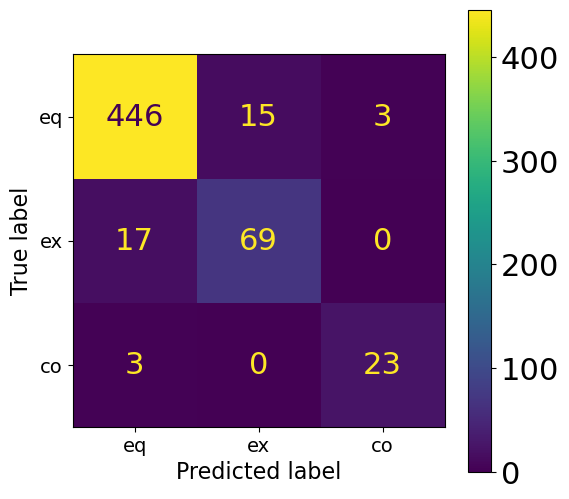

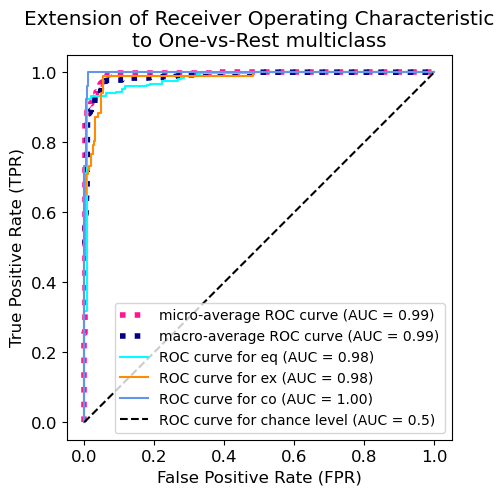

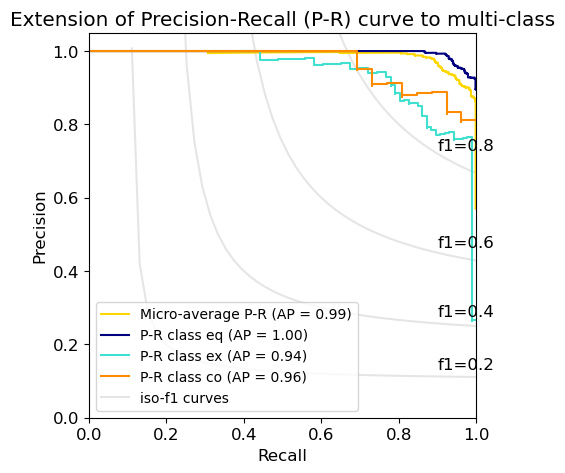

In [55]:
class_labels = ['eq', 'ex', 'co']

multiclass_confusion_matrix( load_qda_grid, class_labels, X_test, y_test )

multiclass_roc_curves( load_qda_grid, class_labels, X_train, y_train, X_test, y_test )

multiclass_precision_recall( load_qda_grid, class_labels, X_train, y_train, X_test, y_test )

# compare all the scores

We reset the index and renumber, then sort by f1-score, recall, auc, accuracy, precision, and average fit time. 

In [56]:
df_scores.reset_index(inplace=True)
# df_scores.drop(index=5, inplace=True)
# df_scores.reset_index(inplace=True)
df_scores.drop(columns=['index'],inplace=True)
df_scores

,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
0,QDA,0.948,0.934,0.888,0.883,0.885,0.988,0.006
1,GNB,0.947,0.936,0.887,0.890,0.889,0.987,0.006
2,ABC,0.976,0.943,0.879,0.939,0.907,0.948,0.039
3,MLP,0.886,0.936,0.904,0.847,0.873,0.988,1.340
4,GPC,0.902,0.934,0.905,0.840,0.870,0.990,14.395
5,RFC,0.968,0.941,0.872,0.951,0.907,0.984,0.458
6,LGR,0.973,0.906,0.762,0.955,0.831,0.971,0.012
7,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005
8,DTC,0.982,0.944,0.857,0.964,0.903,0.981,0.006
9,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.129


In [57]:
df_scores.sort_values(by='f1', ascending=False) 

,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
2,ABC,0.976,0.943,0.879,0.939,0.907,0.948,0.039
5,RFC,0.968,0.941,0.872,0.951,0.907,0.984,0.458
8,DTC,0.982,0.944,0.857,0.964,0.903,0.981,0.006
9,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.129
1,GNB,0.947,0.936,0.887,0.890,0.889,0.987,0.006
0,QDA,0.948,0.934,0.888,0.883,0.885,0.988,0.006
7,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005
3,MLP,0.886,0.936,0.904,0.847,0.873,0.988,1.340
4,GPC,0.902,0.934,0.905,0.840,0.870,0.990,14.395
6,LGR,0.973,0.906,0.762,0.955,0.831,0.971,0.012


In [58]:
df_scores.sort_values(by='recall', ascending=False)

,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
9,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.129
8,DTC,0.982,0.944,0.857,0.964,0.903,0.981,0.006
6,LGR,0.973,0.906,0.762,0.955,0.831,0.971,0.012
5,RFC,0.968,0.941,0.872,0.951,0.907,0.984,0.458
2,ABC,0.976,0.943,0.879,0.939,0.907,0.948,0.039
1,GNB,0.947,0.936,0.887,0.890,0.889,0.987,0.006
0,QDA,0.948,0.934,0.888,0.883,0.885,0.988,0.006
7,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005
3,MLP,0.886,0.936,0.904,0.847,0.873,0.988,1.340
4,GPC,0.902,0.934,0.905,0.840,0.870,0.990,14.395


In [59]:
df_scores.sort_values(by='auc', ascending=False)

,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
4,GPC,0.902,0.934,0.905,0.840,0.870,0.990,14.395
0,QDA,0.948,0.934,0.888,0.883,0.885,0.988,0.006
3,MLP,0.886,0.936,0.904,0.847,0.873,0.988,1.340
1,GNB,0.947,0.936,0.887,0.890,0.889,0.987,0.006
9,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.129
7,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005
5,RFC,0.968,0.941,0.872,0.951,0.907,0.984,0.458
8,DTC,0.982,0.944,0.857,0.964,0.903,0.981,0.006
6,LGR,0.973,0.906,0.762,0.955,0.831,0.971,0.012
2,ABC,0.976,0.943,0.879,0.939,0.907,0.948,0.039


In [60]:
df_scores.sort_values(by='precision', ascending=False)

,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
4,GPC,0.902,0.934,0.905,0.840,0.870,0.990,14.395
3,MLP,0.886,0.936,0.904,0.847,0.873,0.988,1.340
7,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005
0,QDA,0.948,0.934,0.888,0.883,0.885,0.988,0.006
1,GNB,0.947,0.936,0.887,0.890,0.889,0.987,0.006
2,ABC,0.976,0.943,0.879,0.939,0.907,0.948,0.039
5,RFC,0.968,0.941,0.872,0.951,0.907,0.984,0.458
8,DTC,0.982,0.944,0.857,0.964,0.903,0.981,0.006
9,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.129
6,LGR,0.973,0.906,0.762,0.955,0.831,0.971,0.012


In [61]:
df_scores.sort_values(by=['accuracy'], ascending=False)

,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
8,DTC,0.982,0.944,0.857,0.964,0.903,0.981,0.006
2,ABC,0.976,0.943,0.879,0.939,0.907,0.948,0.039
5,RFC,0.968,0.941,0.872,0.951,0.907,0.984,0.458
9,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.129
1,GNB,0.947,0.936,0.887,0.890,0.889,0.987,0.006
3,MLP,0.886,0.936,0.904,0.847,0.873,0.988,1.340
0,QDA,0.948,0.934,0.888,0.883,0.885,0.988,0.006
4,GPC,0.902,0.934,0.905,0.840,0.870,0.990,14.395
7,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005
6,LGR,0.973,0.906,0.762,0.955,0.831,0.971,0.012


In [62]:
df_scores.sort_values(by=['fit_time'], ascending=False)

,CLF,train_score,accuracy,precision,recall,f1,auc,fit_time
4,GPC,0.902,0.934,0.905,0.840,0.870,0.990,14.395
3,MLP,0.886,0.936,0.904,0.847,0.873,0.988,1.340
5,RFC,0.968,0.941,0.872,0.951,0.907,0.984,0.458
9,SVC,0.980,0.939,0.856,0.965,0.903,0.987,0.129
2,ABC,0.976,0.943,0.879,0.939,0.907,0.948,0.039
6,LGR,0.973,0.906,0.762,0.955,0.831,0.971,0.012
0,QDA,0.948,0.934,0.888,0.883,0.885,0.988,0.006
1,GNB,0.947,0.936,0.887,0.890,0.889,0.987,0.006
8,DTC,0.982,0.944,0.857,0.964,0.903,0.981,0.006
7,KNN,1.000,0.932,0.894,0.857,0.875,0.986,0.005


In [63]:
# select the 6 best classifiers in terms of highest f1-score, recall, and precsion, avg_fit_time
# for each 3 do...

# LGR SVC GPC MLP RFC QDA

In [64]:
# from sklearn.metrics import SCORERS
# sorted(SCORERS.keys())